In [1]:
from pysal.esda.getisord import G_Local
import geopandas as gpd
import pandas as pd
import pysal
import numpy as np
%matplotlib inline

In [2]:
def crs_prepossess(gpdf, bfr_crs, init_crs=4326):
    """
    create a shallow copy of gpdf; check the init crs of gpdf, if None, assign init_crs; change crs of copy to bfr_crs
    :param gpdf: geopandas.GeoDataFrame
    :param init_crs: init_crs epsg code
    :param bfr_crs: target crs epsg code used for buffering
    :return: a shallow copy of gpdf in bfr_crs
    """
    gpdf_crs = gpdf.copy()
    if gpdf_crs.crs == None:
        gpdf_crs.crs = {'init': u'epsg:{}'.format(init_crs)}
    return gpdf_crs.to_crs(epsg=bfr_crs)

In [3]:
seg = gpd.read_file('d:/★★学习工作/Life in Maryland/Research Project：CyclingSafe/Cycling_safety/open_data_analysis/data/segments_dc.geojson')
csl = pd.read_csv('data/y_csl_all-2017-11-07.csv',index_col=0)
x = pd.read_csv('data/x_NO_TOTAL_~2014.csv',index_col=0)
csl.index.name = 'index'
x.index.name = 'index'
geom_seg = crs_prepossess(seg[['geometry']], 3559)

In [8]:
dbs = [10, 50, 100, 150, 200, 300, 400]

# G* for CSL

In [100]:
seg_csl = csl.join(geom_seg).reset_index()
y = seg_csl.csl

In [28]:
binary=True
lgstars = {}

for d in dbs:
    w = pysal.weights.DistanceBand.from_dataframe(seg_csl, threshold=d, binary=binary, silent=True)
    lgstar = G_Local(y, w, star=True, transform='B')
    lgstars[d] = lgstar

d: 10
d: 50
d: 100
d: 150
d: 200
d: 300
d: 400


In [54]:
def count_spots(lgstars, dbs):
    res = []
    for d in dbs:
        lgstar = lgstars[d]
        sig_norm = lgstar.p_norm<0.05
        neg_Zs = lgstar.Zs<0
        pos_Zs = lgstar.Zs>0
        res.append({
            'dist band(m)': d,
            'hot': (sig_norm & pos_Zs).sum(),
            'cold': (sig_norm & neg_Zs).sum(),
            'total': sig_norm.sum()
        })
    df = pd.DataFrame(res)
    return df[['dist band(m)', 'total', 'hot', 'cold']]

In [55]:
count_spots(lgstars, dbs)

,dist band(m),total,hot,cold
0,10,45,16,29
1,50,48,16,32
2,100,81,32,49
3,150,121,61,60
4,200,130,62,68
5,300,161,79,82
6,400,166,71,95


In [162]:
lgstar150 = lgstars[150]
sig_norm = lgstar150.p_norm<0.05
neg_Zs = lgstar150.Zs<0
pos_Zs = lgstar150.Zs>0
seg_csl_temp = seg_csl
seg_csl_temp['p_norm'] = lgstar150.p_norm
seg_csl_temp['hot'] = sig_norm & pos_Zs
seg_csl_temp['cold']= sig_norm & neg_Zs
seg_csl_temp['spot'] = seg_csl.apply(lambda x: 'hot' if x.hot else 'cold' if x.cold else 'None', axis=1)
seg_csl_temp['Zs'] = lgstar150.Zs
seg_csl_temp.drop(['hot', 'cold'], axis=1, inplace=True)

In [163]:
gpdf = gpd.GeoDataFrame(seg_csl_temp)

In [164]:
gpdf = crs_prepossess(gpdf, bfr_crs=4326, init_crs=3559)

In [165]:
colors ={
    'hot':['#fddbc7', '#ef8a62', '#b2182b'],
    'cold': ['#d1e5f0', '#67a9cf', '#2166ac'],
    'None': '#f7f7f7'
} 

def get_sig_lvl(p):
    if p<0.001:
        return 2
    if p<0.01:
        return 1
    if p<0.05:
        return 0
    return -1

def get_color(row):
    if row.spot=='None': 
        return colors['None']
    return colors[row.spot][row.sig_lvl]


In [166]:
gpdf['sig_lvl'] = gpdf.p_norm.apply(get_sig_lvl)

In [167]:
gpdf['color']= gpdf.apply(get_color, axis=1)

In [169]:
from importlib import reload
import src.leaflet_creation;reload(src.leaflet_creation)
from src.leaflet_creation import create_map_visualization, MAP_LAYERS

html_title = 'localgstar'
file_path = ''
file_name = 'localgstar'
lon, lat = -77.018479, 38.913237 #D.C.
zoom = 13
map_layers = MAP_LAYERS.keys()
init_layers = [list(map_layers)[0], 'csl']
binding_data=[['csl','spots of csl']]
# gpdf1['color'] = '#aa0'
# gpdf2['color'] = '#0a0'
gpdfs = [gpdf]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

# G* for x

In [4]:
ws_db_notbinary = {db: pysal.weights.DistanceBand.from_dataframe(geom_seg[['geometry']], threshold=db, binary=False, silent=True) for db in dbs}
ws_db_binary = {db: pysal.weights.DistanceBand.from_dataframe(geom_seg[['geometry']], threshold=db, binary=True, silent=True) for db in dbs}
islands = [ws_db_notbinary[db].islands.__len__() for db in dbs]
pd.DataFrame(list(zip(dbs, islands)), columns=['band', 'num_islands']).set_index('band').T

D:\ProgramFiles\Anaconda3\lib\site-packages\scipy\sparse\data.py:103: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


band,10,50,100,150,200,300,400
num_islands,13469,10234,1436,211,79,21,11


In [5]:
np.random.seed(12345)

In [ ]:
def compute_gstar(ws, param_list, x, pname):
    res = []

    for i, cname in enumerate(x):
        if i % 40 == 0:
            print('i=', i, cname)
            
        data = x[cname]
        for p in param_list:
            w = ws[p]
            lgstar = G_Local(data, w, star=True)
            res.append({
                'column':cname, 
                pname:p,
                'I': lgstar.I, 
                'EI': lgstar.EI, 
                'p_norm': lgstar.p_norm,
                'p_sim': lgstar.p_sim, 
                'p_z_sim': lgstar.p_z_sim,
                'z_sim': lgstar.z_sim,
            })
            
        if i==3:
            break
        
    print('done computing', pname)
    df = pd.DataFrame(res)
    return df[['column', pname, 'I', 'EI', 'p_norm', 'p_sim', 'p_z_sim']]

In [6]:
lgstar = G_Local(x.iloc[:,0], ws_db_notbinary[400], star=True)

In [7]:
lgstar.z_sim

array([-0.04506776, -0.27665844, -0.41146641, ..., -0.94539   ,
       -1.04936944, -0.80452967])

In [31]:
print(lgstar.n)
sig_idx = lgstar.p_sim<0.05

13522


In [40]:
lgstar.sim

array([[  6.17692347e-05,   6.75426033e-05,   6.92409602e-05, ...,
          5.87880409e-05,   7.94592202e-05,   7.03180119e-05],
       [  8.02922328e-05,   8.27343635e-05,   6.45908786e-05, ...,
          8.21329489e-05,   8.51683943e-05,   7.35560014e-05],
       [  7.93291058e-05,   6.37967295e-05,   6.96868674e-05, ...,
          6.77063365e-05,   7.34398502e-05,   6.20829392e-05],
       ..., 
       [  7.44000119e-05,   7.96296715e-05,   6.47336769e-05, ...,
          6.31136754e-05,   1.10739563e-04,   6.88068830e-05],
       [  7.40024631e-05,   7.13604056e-05,   7.87851248e-05, ...,
          8.10049649e-05,   6.86135790e-05,   6.60940628e-05],
       [  6.67903241e-05,   7.33421899e-05,   7.92006309e-05, ...,
          1.06916012e-04,   8.09085826e-05,   7.82284953e-05]])

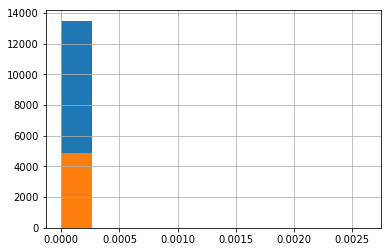

In [33]:
pd.Series(lgstar.Gs).hist()
pd.Series(lgstar.Gs[sig_idx]).hist()

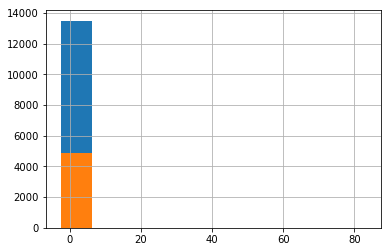

In [34]:
pd.Series(lgstar.z_sim).hist()
pd.Series(lgstar.z_sim[sig_idx]).hist()

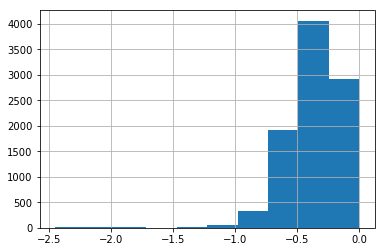

In [38]:
pd.Series(lgstar.z_sim[lgstar.z_sim<0]).hist()